In [2]:
import os
import re
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, welch, detrend, correlate, resample
from sklearn.decomposition import PCA

# DATA PROCESSING

In [3]:
# Initialize list of patients in the dataset
patients = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15"]

# Initialize list of conditions in the dataset
conditions = ["normal", "physical"]

Check if the synchronization between video recording and associated ECG records

In [4]:
def get_video_duration(video_path):
    """
    This function extracts the duration of a video using OpenCV
        Args:
            video_path: Path to the video file
        Returns:
            Duration of the video (s) or None if an error occured (with related error comment)
    """
    if not os.path.exists(video_path):
        print(f"Video file not found, invalid file path: {video_path}")
        return None
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Cannot open video file {video_path}")
        return None
    
    fps = cap.get(cv2.CAP_PROP_FPS)                     # Get frames per second
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)     # Get total frame count
    cap.release()
    
    if fps > 0 and frame_count > 0:
        video_duration = frame_count / fps              # Compute video duration in seconds
        return video_duration
    else:
        print(f"Could not extract FPS or frame count from {video_path}")
        return None

def get_ecg_duration(ecg_path):
    """
    This function extracts the duration of an ECG file based on the number of samples and sampling rate
        Args:
            ecg_path: Path to the ECG file
        Returns:
            Duration of the ECG signal (s) or None if an error occured (with related error comment)
    """
    if not os.path.exists(ecg_path):
        print(f"ECG file not found, invalid file path: {ecg_path}")
        return None
    
    try:
        with open(ecg_path, 'r') as file:
            content = file.read()
            
            # Use regex to extract sampling rate and number of samples
            sampling_rate_match = re.search(r"ADC Sampling rate \(Hz\):\s*(\d+)", content)
            num_samples_match = re.search(r"Number of samples exported by each lead:\s*(\d+)", content)
            
            if sampling_rate_match and num_samples_match:
                sampling_rate = int(sampling_rate_match.group(1))
                num_samples = int(num_samples_match.group(1))
                ecg_duration = num_samples / sampling_rate          # Compute ECG duration in seconds
                return ecg_duration
            else:
                print(f"Could not extract ECG duration from {ecg_path}")
                return None
    except Exception as e:
        print(f"Could not read ECG file {ecg_path} \n Error: {e}")
        return None

def check_alignment(patients, video_folder="data/Video", ecg_folder="data/ECG"):
    """
    This function checks alignment between video and ECG durations for each patient
        Args:
            patients: List of patients
            video_folder: Path to the folder containing the video files
            ecg_folder: Path to the folder containing the ECG files
        Returns:
            Dictionary containing alignment results for each patient and for each condition (normal, physical) with the following information:
            'video_duration', 'ecg_duration', 'difference_seconds', 'aligned': boolean
    """ 
    results = {}
    
    for patient in patients:
        for condition in conditions:
            video_path = os.path.join(video_folder, f"{patient}_{condition}.mp4")
            ecg_path = os.path.join(ecg_folder, f"{patient}_{condition}.txt")
            
            video_duration = get_video_duration(video_path)
            ecg_duration = get_ecg_duration(ecg_path)
            
            if video_duration is not None and ecg_duration is not None:
                difference = abs(video_duration - ecg_duration)
                results[f"{patient}_{condition}"] = {
                    "video_duration": video_duration,
                    "ecg_duration": ecg_duration,
                    "difference_seconds": difference,
                    "aligned": difference < 0.01        # Tolerance of 0.01 second because of ecg sampling rate (100Hz)
                }
            else:
                results[f"{patient}_{condition}"] = "Extraction error"
    
    return results

alignment_results = check_alignment(patients)
for key, value in alignment_results.items():
    print(f"{key}: {value}")

p1_normal: {'video_duration': 23.04, 'ecg_duration': 20.99, 'difference_seconds': 2.0500000000000007, 'aligned': False}
p1_physical: {'video_duration': 22.56, 'ecg_duration': 20.99, 'difference_seconds': 1.5700000000000003, 'aligned': False}
p2_normal: {'video_duration': 21.12, 'ecg_duration': 19.99, 'difference_seconds': 1.1300000000000026, 'aligned': False}
p2_physical: {'video_duration': 22.08, 'ecg_duration': 20.99, 'difference_seconds': 1.0899999999999999, 'aligned': False}
p3_normal: {'video_duration': 21.12, 'ecg_duration': 20.99, 'difference_seconds': 0.13000000000000256, 'aligned': False}
p3_physical: {'video_duration': 21.12, 'ecg_duration': 19.99, 'difference_seconds': 1.1300000000000026, 'aligned': False}
p4_normal: {'video_duration': 21.6, 'ecg_duration': 20.99, 'difference_seconds': 0.610000000000003, 'aligned': False}
p4_physical: {'video_duration': 21.12, 'ecg_duration': 19.99, 'difference_seconds': 1.1300000000000026, 'aligned': False}
p5_normal: {'video_duration': 21.

The videos aren't well aligned with ECG records, we will need to use cross-correlation to make sure our rppg signals extracted from videos are synchronized with ECG signals associated.

### Synchronize ECG Signals and Video extracted signals

In [5]:
def resample_signals(ecg_signal, rppg_signal, ecg_fs, rppg_fs):
    """
        This function resamples ECG and rPPG signals to a common frequency for alignment
            Args:
                ecg_signal: ECG signal
                rppg_signal: rPPG signal
                ecg_fs: ECG sampling frequency
                rppg_fs: rPPG sampling frequency
            Returns:
                Resampled ECG and rPPG signals, and the common sampling frequency
    """
    common_fs = min(ecg_fs, rppg_fs)   # Get minimum sampling frequency to avoid incorrect lag calculation
    ecg_resampled = resample(ecg_signal, int(len(ecg_signal) * common_fs / ecg_fs))
    rppg_resampled = resample(rppg_signal, int(len(rppg_signal) * common_fs / rppg_fs))
    return ecg_resampled, rppg_resampled, common_fs

def cross_correlate(ecg_signal, rppg_signal):
    """
        This function aligns rPPG signal with ECG using cross-correlation to handle signal alignment
            Args:
                ecg_signal: ECG signal
                rppg_signal: rPPG signal
            Returns:
                Lag between ECG and rPPG signals
    """
    min_len = min(len(ecg_signal), len(rppg_signal))
    ecg_signal = ecg_signal[:min_len]
    rppg_signal = rppg_signal[:min_len]
    correlation = correlate(ecg_signal, rppg_signal, mode='full')
    lag = np.argmax(correlation) - (len(rppg_signal) - 1)
    return lag

def align_signals(ecg_signal, rppg_signal, lag):
    """
        This function aligns rPPG and ECG signals based on the computed lag
            Args:
                ecg_signal: ECG signal
                rppg_signal: rPPG signal
                lag: Lag between ECG and rPPG signals
            Returns:
                Aligned ECG and rPPG signals
    """
    if lag > 0:
        aligned_rppg_signal = rppg_signal[lag:]
        aligned_ecg_signal = ecg_signal[:len(aligned_rppg_signal)]
    elif lag < 0:
        aligned_ecg_signal = ecg_signal[-lag:]
        aligned_rppg_signal = rppg_signal[:len(aligned_ecg_signal)]
    else:
        aligned_ecg_signal, aligned_rppg_signal = ecg_signal, rppg_signal
    return aligned_ecg_signal, aligned_rppg_signal

## VIDEO PROCESSING

In this section, we extract RGB values from ROI (Regions of interest) over time.
<br>I started with forehead as ROI but it appears that on some videos the presence of hair biaises the results. So I chose to extract the middle part of cheeks (left and right) as ROI.

In [6]:
mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

def extract_cheeks(video_path):
    """
        This function extracts mean RGB values from cheeks over time
            Args:
                video_path: Path to the video file
            Returns:
                Numpy array containing mean RGB values from both cheeks over time
    """
    cap = cv2.VideoCapture(video_path)
    frame_list_cheeks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        results = mp_face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            for landmarks in results.multi_face_landmarks:
                h, w, _ = frame.shape
                
                # Inner cheek landmarks
                cheek_left_x = int(landmarks.landmark[205].x * w)
                cheek_left_y = int(landmarks.landmark[205].y * h)
                cheek_right_x = int(landmarks.landmark[425].x * w)
                cheek_right_y = int(landmarks.landmark[425].y * h)
                
                # Define small bounding boxes around cheeks
                cheek_left_roi = frame[cheek_left_y-10:cheek_left_y+10, cheek_left_x-10:cheek_left_x+10, :]
                cheek_right_roi = frame[cheek_right_y-10:cheek_right_y+10, cheek_right_x-10:cheek_right_x+10, :]
                
                # Get the mean RGB values from both cheeks
                frame_list_cheeks.append(np.mean([np.mean(cheek_left_roi, axis=(0, 1)), np.mean(cheek_right_roi, axis=(0, 1))], axis=0))
    
    cap.release()
    return np.array(frame_list_cheeks)

## ECG SIGNAL PREPROCESSING

In this part I chose to work with the Lead II from the ECG Signal as its anatomical alignment and high R wave amplitude make it the most reliable lead for heart rate estimation using R peak detection (Journal of Electrocardiology (e.g., Kligfield et al., 2007))
<br>The challenge is to process the ECG Signal without affecting the (P, QRS, T) morphology in order to have a robust heart rate estimation based on ECG records.
<br>I also realized that the ECG record's values were not always coherent with the rest of the values so I added a function to remove those baseline wanders. 
I chose my filters values based on different studies :
-  Kligfield et al. (2007) in the Journal of the American College of Cardiology assumes that the ECG waveforms (P, QRS, T) are primarily contained within 0.5–40 Hz for healthy adults 
-  Sörnmo and Laguna (2005) - "Bioelectrical Signal Processing in Cardiac and Neurological Applications" indicates that the respiratory cycle (~0.1–0.4 Hz) is a major contributor to baseline drift in ECG signals. 
-  Thakor and Zhu (1991) - "Applications of Adaptive Filtering to ECG Analysis: Noise Cancellation and Arrhythmia Detection" demonstrates that a 40 Hz low-pass filter effectively removes high-frequency noise and muscle artifacts from ECG signals.
-  Guyton and Hall Textbook of Medical Physiology indicates that the respiratory rates in adults are typically 12–20 breaths per minute which corresponds to 0.2–0.33 Hz; so I used a 0.5 Hz cutoff to be safely above this range.

In [7]:
def bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=4):
    """
        This function dynamically applies a bandpass filter to isolate ECG frequencies
            Args:
                signal: Numpy array signal
                fs: Sampling frequency
                lowcut: Lowcut frequency
                highcut: Highcut frequency
                order: Filter order
            Returns:
                Filtered ECG signal
    """
    lowcut = max(0.5, 0.005 * fs)
    highcut = min(40.0, 0.4 * fs)

    # Apply bandpass filter
    nyquist = fs / 2.0
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def baseline_wander_removal(signal, fs, cutoff=0.5, order=2):
    """
        This function applies high-pass filter to remove baseline wander
            Args:
                signal: Numpy array signal
                fs: Sampling frequency
                cutoff: Cutoff frequency
                order: Filter order
            Returns:
                Filtered ECG signal
    """
    nyquist = fs / 2.0
    cutoff = max(0.5, 0.005 * fs)
    high = cutoff / nyquist
    b, a = butter(order, high, btype='highpass')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def outlier_removal(signal, threshold=3.5):
    """
        This function removes outliers using robust z-score based on Median Absolute Deviation (MAD)
            Args:
                signal: Numpy array signal
                threshold: Threshold for outlier detection 
                           - Traditional z-score threshold is 3.0, so 3.5 provides slightly more tolerance for variability
            Returns:
                Signal without outliers
    """
    median = np.median(signal)
    mad = np.median(np.abs(signal - median))
    # Avoid division by zero if Median Absolute Deviation is 0
    if mad == 0:
        return signal
    robust_z_scores = 0.6745 * (signal - median) / mad      # 0.6745 is the constant for 75th percentile of standard normal distribution
    mask = np.abs(robust_z_scores) < threshold
    clean_signal = signal[mask]
    return clean_signal

def clean_rr_intervals(rr_intervals):
    """
        This function removes outliers from RR intervals to ensure accurate heart rate estimation
            Args:
                rr_intervals: Numpy array of RR intervals
            Returns:
                Cleaned RR intervals
    """
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    mask = (rr_intervals > mean_rr - 2 * std_rr) & (rr_intervals < mean_rr + 2 * std_rr)
    return rr_intervals[mask]

### HEART RATE ESTIMATION

In [8]:
def estimate_heart_rate(filtered_signal, fs):
    """
        This function estimates heart rate from the filtered signal (rPPG or ECG)
            Args:
                filtered_signal: Filtered signal
                fs: Sampling frequency
            Returns:
                Estimated heart rate and peak indices
    """
    # According to Malik et al. (1996) "Heart Rate Variability: Standards of Measurement, Physiological Interpretation, and Clinical Use"
    # The minimum distance between two R peaks (600 ms=0.6s) is a common threshold to avoid detecting false peaks
    peaks, _ = find_peaks(filtered_signal, distance=fs*0.6)  
    rr_intervals = np.diff(peaks) / fs
    rr_intervals_clean = clean_rr_intervals(rr_intervals)
    return 60 / np.mean(rr_intervals_clean), peaks

### LOAD ECG Files and Process them

In [9]:
def load_ecg(file_path, fs=100):
    """
        This function loads ECG file and extract Lead II signal only
            Args:
                file_path: Path to the ECG file
                fs: Sampling frequency
            Returns:
                Filtered ECG signal (Lead II)
    """
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    ecg_values = []
    is_lead_ii = False
    
    for line in lines:
        if line.startswith("#II[uV]"):
            is_lead_ii = True
            continue
        elif line.startswith("#"):
            is_lead_ii = False
        
        if is_lead_ii:
            try:
                values = list(map(int, line.strip().split()))
                ecg_values.extend(values)
            except ValueError:
                continue

    # Apply ECG-specific preprocessing
    ecg_values = np.array(ecg_values)
    ecg_detrended = detrend(ecg_values)
    ecg_no_outliers = outlier_removal(ecg_detrended)
    ecg_filtered = bandpass_filter(ecg_no_outliers, fs)
    return ecg_filtered

### DATA VISUALIZATION

In [10]:
def visualize_roi_detection(video_path):
    """
        This function visualizes the regions of interest (cheeks) detection on a video
            Args:
                video_path: Path to the video file
            Returns:
                None, opens a window to display the video with rectangles indicating the detected regions
    """
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = mp_face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            for landmarks in results.multi_face_landmarks:
                h, w, _ = frame.shape
                
                # Use inner cheek landmarks for precise visualization
                cheek_left_x = int(landmarks.landmark[205].x * w)
                cheek_left_y = int(landmarks.landmark[205].y * h)
                cheek_right_x = int(landmarks.landmark[425].x * w)
                cheek_right_y = int(landmarks.landmark[425].y * h)
                
                # Get small squares for cheeks region analysis
                cv2.rectangle(frame, (cheek_left_x-10, cheek_left_y-10), (cheek_left_x+10, cheek_left_y+10), (0, 255, 0), 2)
                cv2.rectangle(frame, (cheek_right_x-10, cheek_right_y-10), (cheek_right_x+10, cheek_right_y+10), (0, 255, 0), 2)
        
        cv2.imshow('ROI Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

def plot_ecg_signal(ecg_signal, fs):
    """
        This function plots the ECG signal for analysis with detected peaks
            Args:
                ecg_signal: ECG signal
                fs: Sampling frequency
            Returns:
                None, opens a plot to display the ECG signal with detected peaks
    """
    time_axis = np.arange(len(ecg_signal)) / fs
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6)
    
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, ecg_signal, label='ECG Lead II')
    plt.scatter(time_axis[peaks], ecg_signal[peaks], color='red', label='Detected Peaks', zorder=5)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (uV)")
    plt.title("ECG Signal with Detected Peaks")
    plt.legend()
    plt.grid()
    plt.show()

def plot_spectrum(signal, fs, title="Power Spectrum"):
    """
        This function plots frequency spectrum of the signal extracted from video
            Args:
                signal: Signal to analyze
                fs: Sampling frequency
                title: Title of the plot
            Returns:
                None, opens a plot to display the power spectrum of the signal
    """
    freqs, power = welch(signal, fs=fs, nperseg=256)
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, power)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(title)
    plt.xlim(0.5, 4)
    plt.grid()
    plt.show()

### MAIN EXECUTION PIPELINE

In [11]:
def process_video_and_ecg(video_path, ecg_path, fs=25):

    cheeks_rgb = extract_cheeks(video_path)
    
    # Extract Green Channel from Cheeks to analyse skin color changes due to blood volume fluctuations
    green_cheeks = cheeks_rgb[:, 1]
    rppg_signal = bandpass_filter(green_cheeks, fs)
    
    # Load ECG Signal
    ecg_signal = load_ecg(ecg_path)

    # Resample and Align Signals
    ecg_resampled, rppg_resampled, common_fs = resample_signals(ecg_signal, rppg_signal, ecg_fs=100, rppg_fs=fs)
    lag = cross_correlate(ecg_resampled, rppg_resampled)
    ecg_signal, rppg_signal = align_signals(ecg_signal, rppg_signal, lag)
    
    # Estimate rPPG Heart Rate
    rppg_hr, rppg_peaks = estimate_heart_rate(rppg_signal, fs)
    print(f"Estimated rPPG Heart Rate: {rppg_hr:.2f} BPM")
    
    # Compute ECG Heart Rate
    ecg_hr, ecg_peaks = estimate_heart_rate(ecg_signal, fs=100)
    print(f"Estimated ECG Heart Rate: {ecg_hr:.2f} BPM")
    
    # Plot results
    plot_spectrum(rppg_signal, fs, "rPPG Power Spectrum")
    visualize_roi_detection(video_path)
    
    return rppg_hr, ecg_hr

p1 in normal condition: 
Estimated rPPG Heart Rate: 69.23 BPM
Estimated ECG Heart Rate: 70.04 BPM


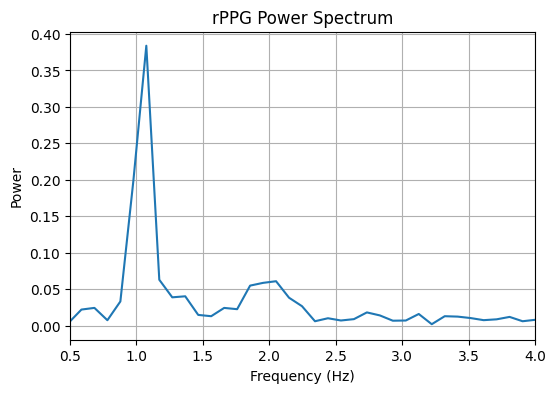

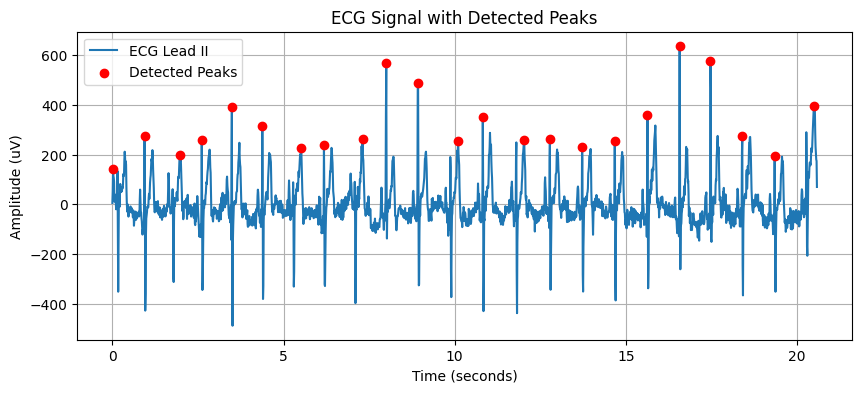

p1 in physical condition: 
Estimated rPPG Heart Rate: 73.77 BPM
Estimated ECG Heart Rate: 73.17 BPM


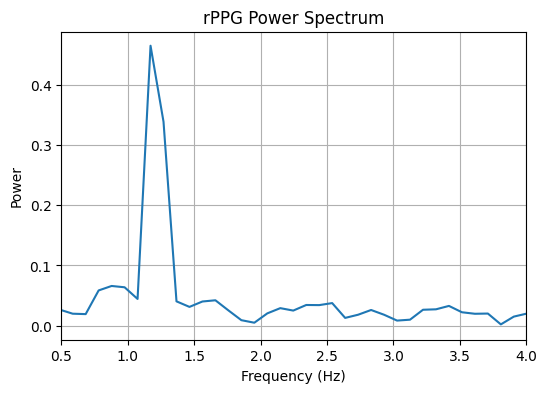

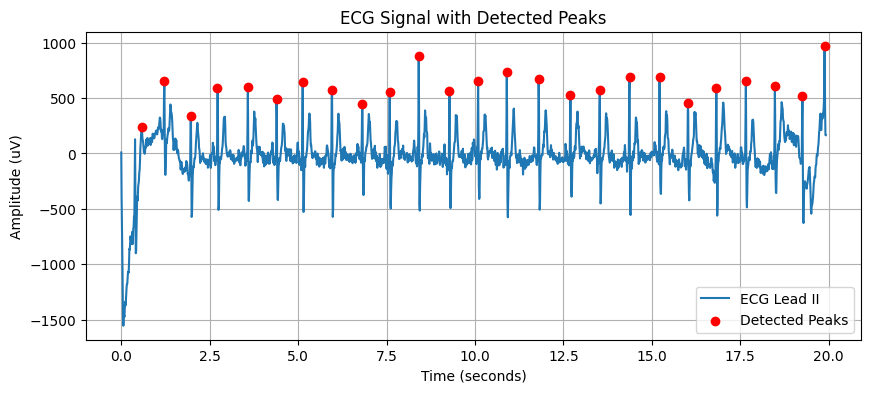

p2 in normal condition: 
Estimated rPPG Heart Rate: 75.80 BPM
Estimated ECG Heart Rate: 87.98 BPM


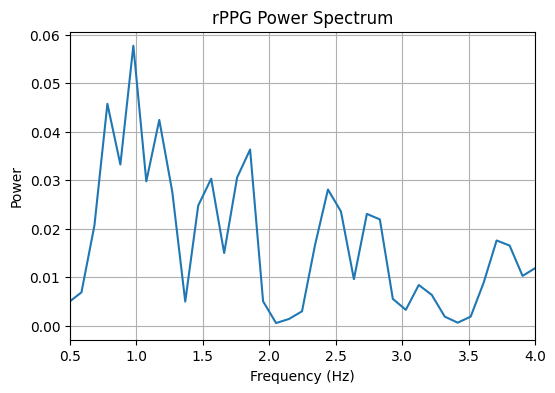

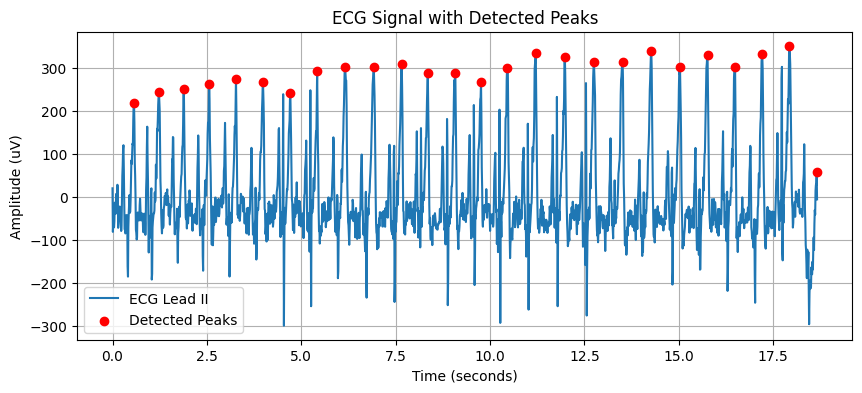

p2 in physical condition: 
Estimated rPPG Heart Rate: 80.00 BPM
Estimated ECG Heart Rate: 77.59 BPM


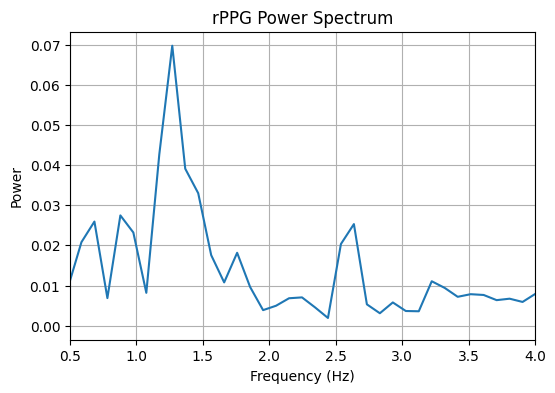

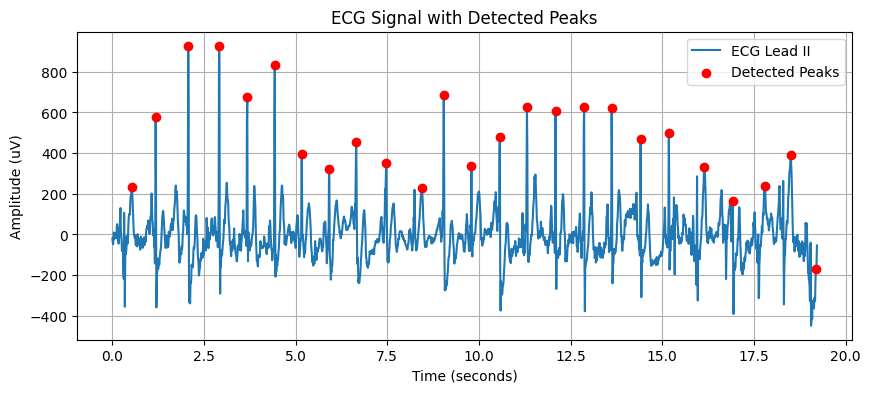

p3 in normal condition: 
Estimated rPPG Heart Rate: 64.07 BPM
Estimated ECG Heart Rate: 62.34 BPM


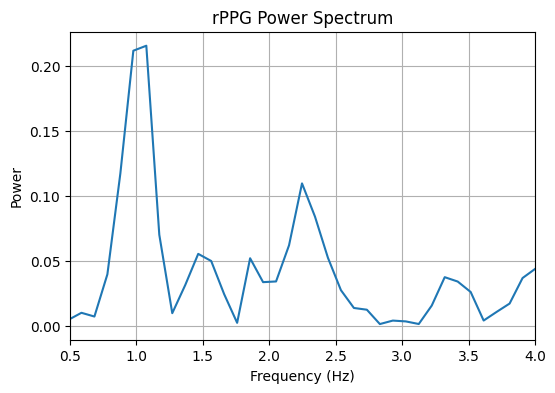

KeyboardInterrupt: 

In [12]:
# Run the pipeline for all patients
patients = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15"]
conditions = ["normal", "physical"]
for patient in patients:
    for condition in conditions:
        print(f"{patient} in {condition} condition: ")
        video_path = f"data/Video/{patient}_{condition}.mp4"
        ecg_path = f"data/ECG/{patient}_{condition}.txt"
        process_video_and_ecg(video_path, ecg_path)
        ecg_signal = load_ecg(ecg_path)
        plot_ecg_signal(ecg_signal, fs=100)